Saturation curves for SM-omics and ST<br>

Input files are generated by counting number of unique molecules and number of annotated reads per annotated region after adjusting for sequencing depth, in downsampled fastq files (proportions 0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1) processed using ST-pipeline.<br>

data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/<br>
please download:<br>
10005CN48_C1_uniq_molecules_per_region_adjusted_after_seq_depth_on_satRationXtot_count.txt<br>
10005CN48_D1_uniq_molecules_per_region_adjusted_after_seq_depth_on_satRationXtot_count.txt<br>
10005CN48_E1_uniq_molecules_per_region_adjusted_after_seq_depth_on_satRationXtot_count.txt<br>
10015CN60_E2_uniq_molecules_per_region_adjusted_after_seq_depth_on_satRationXtot_count.txt<br>
10015CN84_C2_uniq_molecules_per_region_adjusted_after_seq_depth_on_satRationXtot_count.txt<br>
10015CN84_D2_uniq_molecules_per_region_adjusted_after_seq_depth_on_satRationXtot_count.txt<br>

To generate SM-omics vs Visium, saturation curve for the entire tissue section, download:<br>
10015CN108_C1_uniq_molecules.txt<br>
10015CN108fl_E2_uniq_molecules.txt<br>
5005CN107_D2_uniq_molecules.txt<br>
visium_A1_uniq_molecules.txt<br>
visium_B1_uniq_molecules.txt<br>
visium_D1_uniq_molecules.txt <br>


In [53]:
%matplotlib inline
import os
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import glob
import warnings
from scipy.stats import ranksums, ttest_ind
warnings.filterwarnings('ignore')

In [54]:
def condition(row):
    """ Takes row in pandas df as input and returns type of condition
    """
    # The samples are run in triplicate based on condition
    condition = ['sm-omics', 'ST']

    if row['Name'] in ['10015CN84_D2', '10015CN84_C2', '10015CN60_E2']:
        return condition[0]
    
    elif row['Name'] in ['10005CN48_C1','10005CN48_D1','10005CN48_E1']:
        return condition[1]
    

In [92]:
# Load input files
path = '../../smomics_data'

stats_list = []

samples_list = ['10005CN48_C1', '10005CN48_D1', '10005CN48_E1', '10015CN84_D2', '10015CN84_C2', '10015CN60_E2']
    
for filename in samples_list:
    
    cond_file = pd.read_csv(os.path.join(path, filename + '_uniq_molecules_per_region_adjusted_after_seq_depth_on_satRationXtot_count.txt'), sep = '\t')
    if numpy.unique(cond_file['Name']) == '10005CN60_E2':
        cond_file['Name'] = '10015CN60_E2'
    cond_file['Condition'] = cond_file.apply(lambda row: condition(row), axis = 1)

    stats_list.append(cond_file)

# Concat all files
cond_merge = pd.concat(stats_list)
    

In [96]:
prop_list = [0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1]

cond_list = []
for label, df in cond_merge.groupby(['Condition', 'Name', 'Annotated_region']):
    
    # Sort df by annotated reads
   
    df.sort_values(by='Annotated_reads', inplace=True)
    
    df['Prop_annot_reads'] = prop_list
        
    cond_list.append(df)
    
# Concatenate all dfs in list
plot_df_tmp = pd.concat(cond_list)

# Remove 'unknown' regions, if any
plot_df_big = plot_df_tmp[plot_df_tmp['Annotated_region'] != 'Unknown']
plot_df_big_max = plot_df_big[plot_df_big['Prop_annot_reads'] == 1.000]

In [97]:
numpy.unique(plot_df_tmp['Name'])

array(['10005CN48_C1', '10005CN48_D1', '10005CN48_E1', '10015CN60_E2',
       '10015CN84_C2', '10015CN84_D2'], dtype=object)

In [98]:
# Prepare samples for plotting
ll = []

for label, df in plot_df_big.groupby(['Name']):
    # Get max annotated reads
    max_annot = df['Annotated_reads'].max()
    
    # Get tot number of uniq mol at that amount of annotated reads
    tot_uniq_mol = df[df['Annotated_reads'] == max_annot]['Unique_molecules'].sum()
       
    df['Prop_uniq_mol'] = df['Unique_molecules'] / tot_uniq_mol
    ll.append(df)

# Concatenate all dfs in list
prop_df = pd.concat(ll)
plot_dict = {}

# Get a df per annotated region
for label, df in prop_df.groupby(['Annotated_region']):
        
    #df.drop(['Num reads', 'Annotated_reads', 'Unique_molecules'], axis=1, inplace=True)

    plot_dict[label] = df

plot_dict_all = {}
    
for label in ['sm-omics', 'ST']:
    df = plot_df_big[plot_df_big['Condition'] == label]
    df = df.groupby(['Condition', 'Name', 'Prop_annot_reads']).sum()    
    df['Prop_annot_reads'] = list(df.index.get_level_values(2))
    df['Condition'] = list(df.index.get_level_values(0))
    plot_dict_all[label] = df

In [99]:
plot_dict

{'GL':             Name Annotated_region  Unique_molecules  Number of genes  \
 0   10005CN48_C1               GL           43412.0             8484   
 12  10005CN48_C1               GL           52574.0             9081   
 30  10005CN48_C1               GL           87580.0            10375   
 42  10005CN48_C1               GL          122862.0            10927   
 48  10005CN48_C1               GL          175650.0            11293   
 6   10005CN48_C1               GL          244783.0            11170   
 18  10005CN48_C1               GL          268857.0            10459   
 24  10005CN48_C1               GL          266341.0             9687   
 36  10005CN48_C1               GL          263471.0             8947   
 0   10005CN48_D1               GL           35591.0             8017   
 12  10005CN48_D1               GL           43591.0             8624   
 30  10005CN48_D1               GL           74267.0            10096   
 42  10005CN48_D1               GL          1

GL
GR
IPL
MI
ONL
OPL


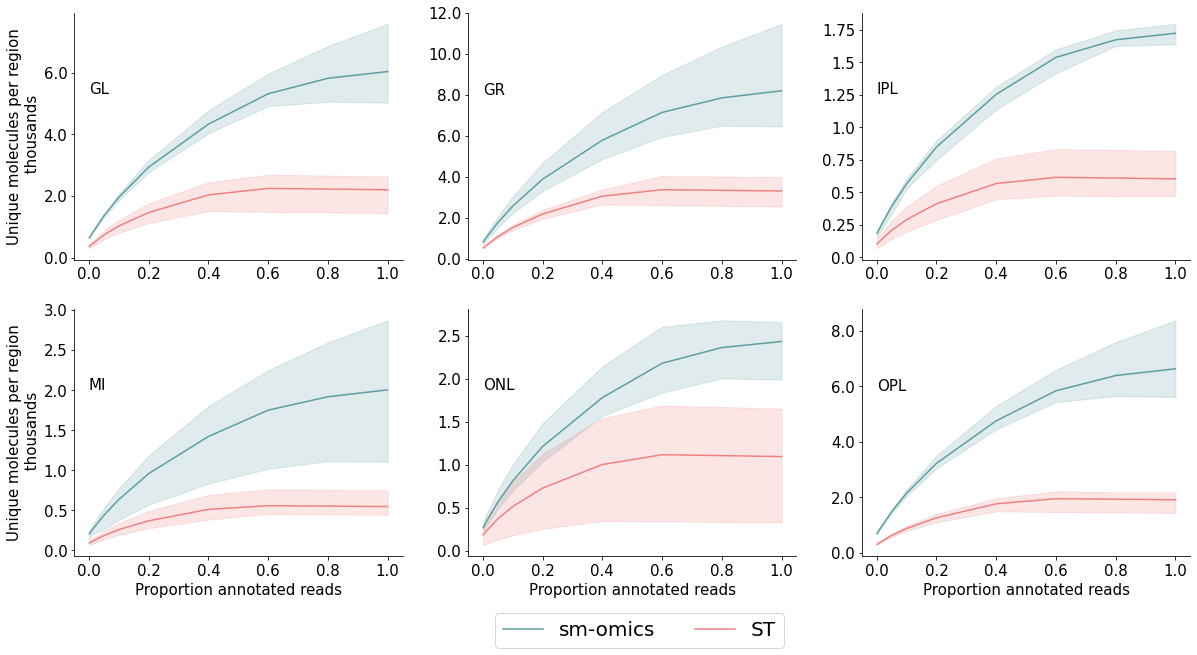

In [100]:
#Plot 
fig = plt.figure(figsize=(20, 10))
# for a 2x3 subplot
axes = []
for row_idx in range(0,2):
    for col_idx in range(0,3):
        ax = plt.subplot2grid((2, 3), (row_idx, col_idx))
        axes.append(ax) 

x="Prop_annot_reads"
y="Unique_molecules"
hue='Condition'
hue_order=['sm-omics', 'ST']
palette = ['cadetblue', 'lightcoral']
err_style="band"
ci=95

################ LINE PLOT
count = 0
for key, value in plot_dict.items():
    
    ax=axes[count]
    print(key)
    #print(value)
    
    if count == 4:
        sns.lineplot(x=x, y=y, data=value, ci=ci, err_style=err_style, hue=hue, 
                 palette = palette, ax=ax, hue_order=hue_order)
    else:
        sns.lineplot(x=x, y=y, data=value, ci=ci, err_style=err_style, hue=hue, 
                 palette = palette, ax=ax, hue_order=hue_order, 
                legend=False)
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k')
    
    # X and y label size
    if count in [3, 4, 5]:
        ax.set_xlabel("Proportion annotated reads", fontsize=15)
    else:
        ax.set_xlabel("")
        
    if count in [0, 3]:
        ax.set_ylabel("Unique molecules per region\n thousands", fontsize=15)
    else:
        ax.set_ylabel("")
    
    # Set ticks size
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)
    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(float(x/100000), ',')))
    
    # change background color
    back_c = 'white'
    ax.set_facecolor(back_c)
    ax.grid(False)
    
    # text
    ax.text(0, max(value[y])-0.3*max(value[y]), key, fontsize=15)
    
    count += 1

# LEGEND
handles, labels = axes[4].get_legend_handles_labels()
axes[4].legend(handles=handles[0:], labels=hue_order,loc='center left', bbox_to_anchor=(0.05, -0.3), ncol=2, fontsize=20)

fig.set_size_inches(20, 10)
plt.savefig("../../figures/umi_saturation_per_region_sm_st.pdf", transparent=True, bbox_inches = 'tight',
   pad_inches = 0, dpi=1200)

plt.show()

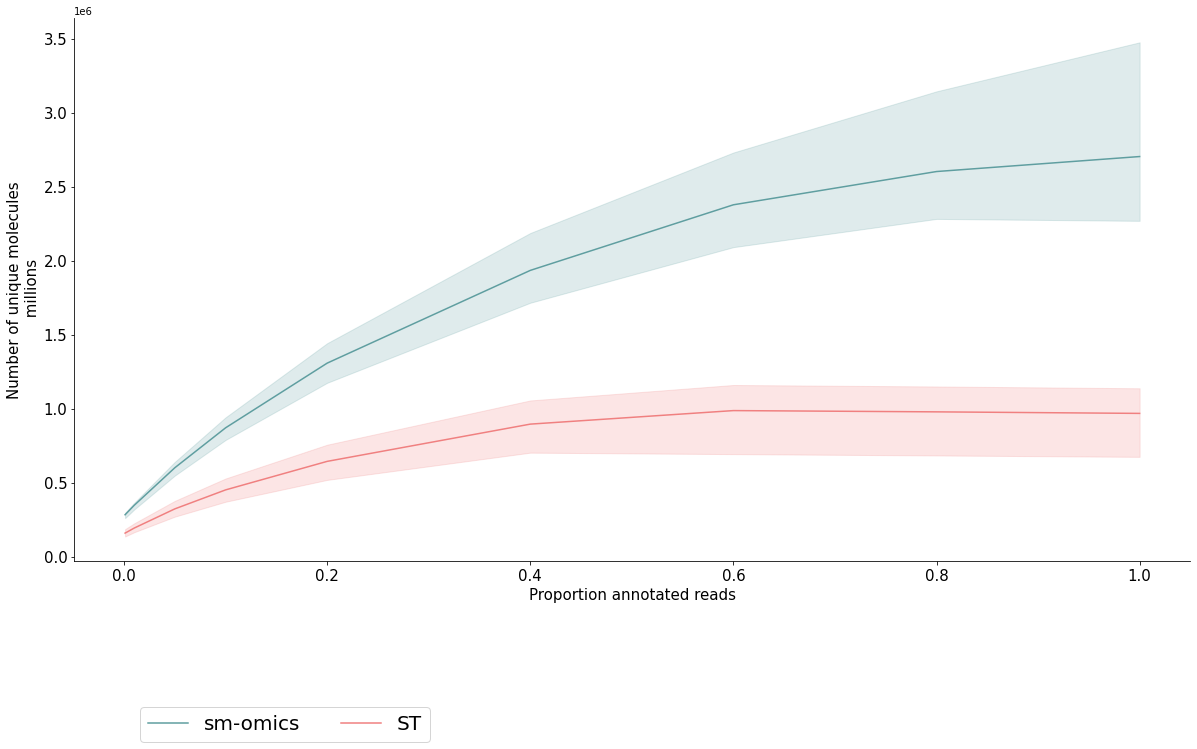

In [101]:
#Plot 
fig = plt.figure(figsize=(5, 5)) 

x="Prop_annot_reads"
y="Unique_molecules"
hue='Condition'
hue_order=['sm-omics', 'ST']
palette = ['cadetblue', 'lightcoral']
err_style="band"
ci=95

################ LINE PLOT
count = 0
for key, value in plot_dict_all.items():
    
    #print(key)
    #print(value)
    
    ax = sns.lineplot(x=x, y=y, data=value, ci=ci, err_style=err_style, hue=hue, 
                 palette = palette, hue_order=hue_order, )
     
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k')
    
    # X and y label size
    ax.set_xlabel("Proportion annotated reads", fontsize=15)
    ax.set_ylabel("Number of unique molecules\n millions", fontsize=15)
    
    # Set ticks size
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)
    
    # change background color
    back_c = 'white'
    ax.set_facecolor(back_c)
    ax.grid(False)
    

# LEGEND
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=hue_order,loc='center left', bbox_to_anchor=(0.05, -0.3), ncol=2, fontsize=20)
        
fig.set_size_inches(20, 10)
plt.savefig("../../figures/umi_saturation_total_sm_st.pdf", transparent=True, bbox_inches = 'tight',
   pad_inches = 0, dpi=1200)
plt.show()

In [102]:
# Calculate statistical tests
for key, cond_merge in plot_dict.items():
    print(key)
    #print(cond_merge.head())
    st = plot_df_big_max[(plot_df_big_max['Annotated_region'] == key) & (plot_df_big_max['Condition'] == 'ST')]['Unique_molecules'].tolist()
    sm = plot_df_big_max[(plot_df_big_max['Annotated_region'] == key) & (plot_df_big_max['Condition'] == 'sm-omics')]['Unique_molecules'].tolist()
    # The Wilcoxon rank-sum test tests the null hypothesis that two sets of measurements are drawn from the same distribution.
#     print('Wilcoxon’s rank sum test')
#     print(ranksums(sm, st))
    #Calculate the T-test for the means of two independent samples of scores.
    print('Welch’s t-test')
    print(ttest_ind(sm, st, equal_var=False))

GL
Welch’s t-test
Ttest_indResult(statistic=4.395814369570281, pvalue=0.023683510264069334)
GR
Welch’s t-test
Ttest_indResult(statistic=2.8989526031070563, pvalue=0.08792062774132377)
IPL
Welch’s t-test
Ttest_indResult(statistic=9.499019892994255, pvalue=0.003804273941833806)
MI
Welch’s t-test
Ttest_indResult(statistic=2.803356662706611, pvalue=0.09862593062913458)
ONL
Welch’s t-test
Ttest_indResult(statistic=2.953391366122583, pvalue=0.056543793981119354)
OPL
Welch’s t-test
Ttest_indResult(statistic=5.188816554719126, pvalue=0.026100560601227566)


In [103]:
# Calculate statistical tests
st = plot_df_big_max[(plot_df_big_max['Condition'] == 'ST')].groupby(['Name']).sum()['Unique_molecules'].tolist()
sm = plot_df_big_max[(plot_df_big_max['Condition'] == 'sm-omics')].groupby(['Name']).sum()['Unique_molecules'].tolist()

#Calculate the T-test for the means of two independent samples of scores.
print('Welch’s t-test')
print(ttest_ind(sm, st, equal_var=False))

Welch’s t-test
Ttest_indResult(statistic=4.191941865964057, pvalue=0.033370298301178804)


In [113]:
plot_df_big_max[(plot_df_big_max['Condition'] == 'ST')].groupby(['Annotated_region']).mean().drop(['Num reads', 'Annotated_reads', 'Prop_annot_reads'], axis = 1)

,Unique_molecules,Number of genes
Annotated_region,,
GL,220137.666667,8590.666667
GR,331461.000000,8593.333333
IPL,60268.666667,7606.666667
MI,54628.000000,7481.333333
ONL,109246.000000,7906.666667
OPL,191639.666667,8559.666667


In [112]:
plot_df_big_max[(plot_df_big_max['Condition'] == 'ST')].groupby(['Annotated_region']).std().drop(['Num reads', 'Annotated_reads', 'Prop_annot_reads'], axis = 1)

,Unique_molecules,Number of genes
Annotated_region,,
GL,65673.467689,853.258656
GR,71838.418280,847.316548
IPL,18797.937236,728.107364
MI,17390.543379,775.935779
ONL,68533.197766,1463.500028
OPL,41448.460060,846.807141


In [111]:
100*plot_df_big_max[(plot_df_big_max['Condition'] == 'ST')].groupby(['Annotated_region']).std().drop(['Num reads', 'Annotated_reads', 'Prop_annot_reads'], axis = 1)/plot_df_big_max[(plot_df_big_max['Condition'] == 'ST')].groupby(['Annotated_region']).mean().drop(['Num reads', 'Annotated_reads', 'Prop_annot_reads'], axis = 1)

,Unique_molecules,Number of genes
Annotated_region,,
GL,29.832908,9.932392
GR,21.673264,9.860162
IPL,31.190232,9.571964
MI,31.834487,10.371624
ONL,62.732913,18.509697
OPL,21.628330,9.892992


In [107]:
plot_df_big_max[(plot_df_big_max['Condition'] == 'sm-omics')].groupby(['Name']).sum().drop(['Num reads', 'Annotated_reads', 'Prop_annot_reads'], axis = 1)

,Unique_molecules,Number of genes
Name,,
10015CN60_E2,3474520.0,63218
10015CN84_C2,2365597.0,53374
10015CN84_D2,2268410.0,54537


In [108]:
plot_df_big_max[(plot_df_big_max['Condition'] == 'ST')].groupby(['Name']).sum().drop(['Num reads', 'Annotated_reads', 'Prop_annot_reads'], axis = 1)

,Unique_molecules,Number of genes
Name,,
10005CN48_C1,1137129.0,52112
10005CN48_D1,1091312.0,51520
10005CN48_E1,673702.0,42583


In [110]:
plot_df_big_max[(plot_df_big_max['Condition'] == 'sm-omics')].groupby(['Name']).sum().drop(['Num reads', 'Annotated_reads', 'Prop_annot_reads'], axis = 1)

,Unique_molecules,Number of genes
Name,,
10015CN60_E2,3474520.0,63218
10015CN84_C2,2365597.0,53374
10015CN84_D2,2268410.0,54537
